In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb


In [ ]:
def load_and_clean_data(filepath):
    print("Loading dataset...")
    df = pd.read_csv(filepath)
    
    valid_labels = [
        'Non-Crypto', 'PRNG', 'RSA-1024', 'RSA-4096', 'ECC', 
        'XOR-CIPHER', 'SHA-1', 'SHA-224', 'AES-128', 'AES-192', 'AES-256'
    ]
    df_clean = df[df['label'].isin(valid_labels)].copy()
    
    cols_to_drop = ['filename', 'function_name', 'function_address', 
                    'source_file', 'algorithm'] # algorithm is redundant with label
    df_clean = df_clean.drop(columns=cols_to_drop, errors='ignore')
    
    bool_cols = ['has_aes_sbox', 'rsa_bigint_detected', 'has_aes_rcon', 'has_sha_constants']
    replace_dict = {'FALSE': 0, 'TRUE': 1, 'False': 0, 'True': 1, False: 0, True: 1}
    
    for col in bool_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna(0).map(replace_dict).fillna(0)


    cat_cols = ['architecture', 'compiler', 'optimization', 'label']
    num_cols = [c for c in df_clean.columns if c not in cat_cols]
    
    for col in num_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        
    initial_count = len(df_clean)
    df_clean = df_clean.dropna()
    print(f"Cleaned data: Kept {len(df_clean)} rows out of {initial_count} valid label rows.")
    
    return df_clean, cat_cols, num_cols


df, cat_cols, num_cols = load_and_clean_data('dataset.csv')

Loading dataset...
Cleaned data: Kept 7654 rows out of 7654 valid label rows.


In [ ]:
X = df.drop(columns=['label'])
y = df['label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

categorical_features = ['architecture', 'compiler', 'optimization']
numerical_features = [c for c in X.columns if c not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


Training Models...
Training RandomForest...
--- RandomForest Results ---
Accuracy: 0.8602
              precision    recall  f1-score   support

     AES-128       0.30      0.32      0.31        19
     AES-192       0.93      0.62      0.74        21
     AES-256       0.24      0.30      0.27        20
         ECC       0.84      1.00      0.91        64
  Non-Crypto       1.00      0.97      0.98      1053
        PRNG       0.98      0.99      0.99       112
    RSA-1024       0.13      0.16      0.14        64
    RSA-4096       0.14      0.15      0.15        65
       SHA-1       0.59      0.53      0.56        32
     SHA-224       0.56      0.56      0.56        32
  XOR-CIPHER       0.88      0.92      0.90        49

    accuracy                           0.86      1531
   macro avg       0.60      0.59      0.59      1531
weighted avg       0.87      0.86      0.87      1531



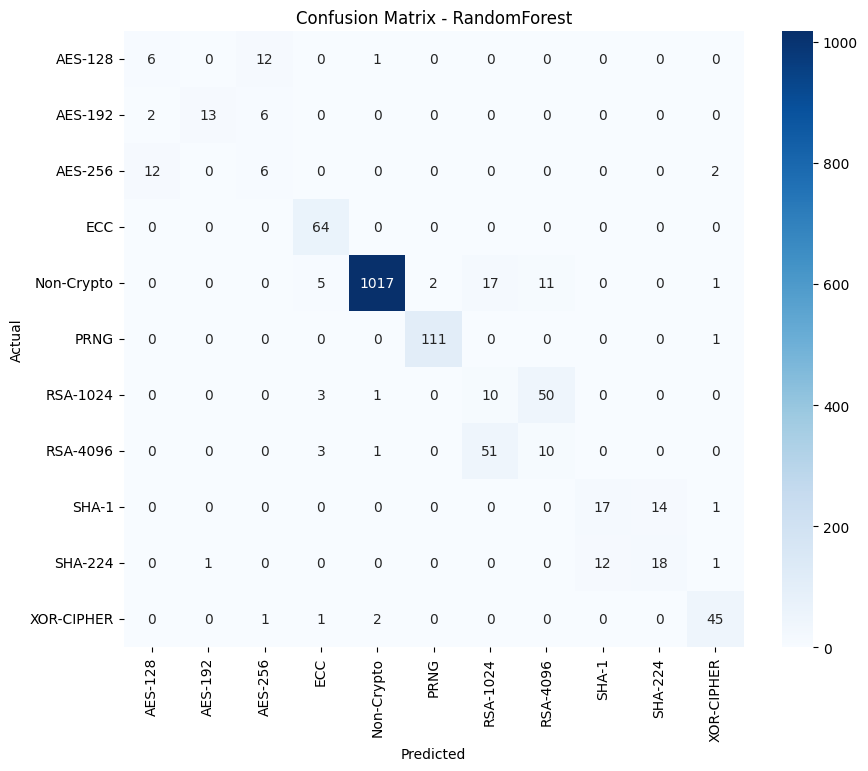

Training XGBoost...


/home/bhoomi/Desktop/compilerRepo/vestigo-data/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [15:01:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost Results ---
Accuracy: 0.8674
              precision    recall  f1-score   support

     AES-128       0.30      0.32      0.31        19
     AES-192       0.93      0.67      0.78        21
     AES-256       0.24      0.30      0.27        20
         ECC       0.91      0.97      0.94        64
  Non-Crypto       1.00      0.97      0.98      1053
        PRNG       0.99      1.00      1.00       112
    RSA-1024       0.11      0.12      0.12        64
    RSA-4096       0.16      0.18      0.17        65
       SHA-1       0.67      0.56      0.61        32
     SHA-224       0.61      0.69      0.65        32
  XOR-CIPHER       0.92      0.96      0.94        49

    accuracy                           0.87      1531
   macro avg       0.62      0.61      0.61      1531
weighted avg       0.88      0.87      0.87      1531



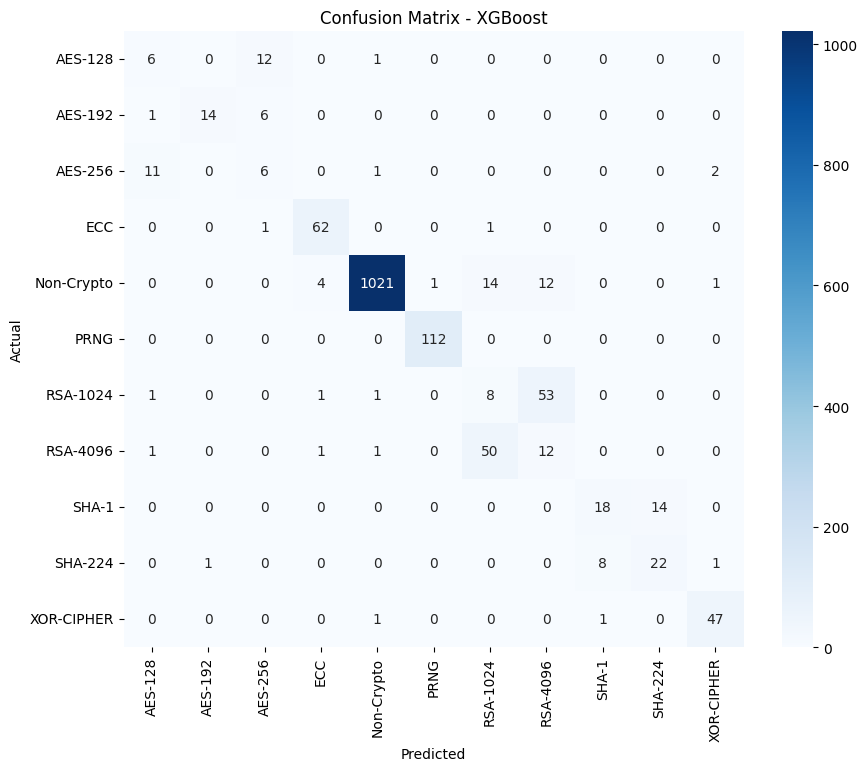

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,             
    min_samples_leaf=2,      
    class_weight='balanced',  
    random_state=42,
    n_jobs=-1
)

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,             
    subsample=0.8,           
    colsample_bytree=0.8,     
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    use_label_encoder=False
)

pipelines = {
    'RandomForest': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rf_model)]),
    'XGBoost': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', xgb_model)])
}

results = {}

print("\nTraining Models...")
for name, pipe in pipelines.items():
    print(f"Training {name}...")
    
    if name == 'XGBoost':
        pipe.fit(X_train, y_train, classifier__sample_weight=sample_weights)
    else:
        pipe.fit(X_train, y_train)
        
    y_pred = pipe.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=class_names)
    results[name] = report
    
    print(f"--- {name} Results ---")
    print(f"Accuracy: {acc:.4f}")
    print(report)
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

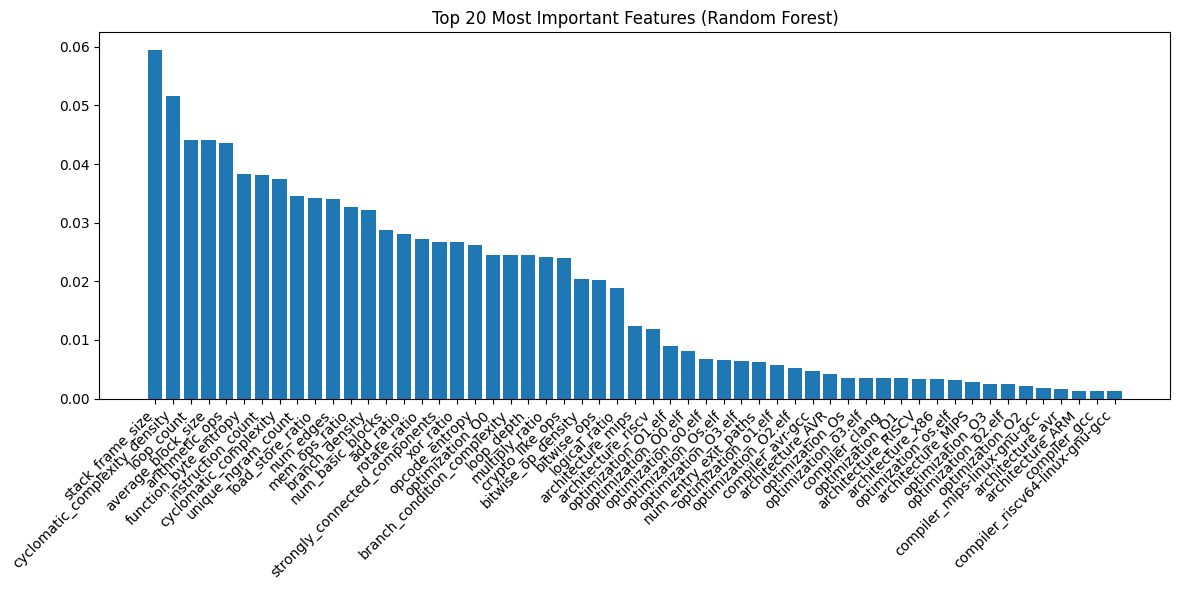

In [9]:
ohe = pipelines['RandomForest'].named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(ohe_feature_names)

importances = pipelines['RandomForest'].named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Top 20 Most Important Features (Random Forest)")
plt.bar(range(55), importances[indices[:55]], align="center")
plt.xticks(range(55), [all_feature_names[i] for i in indices[:55]], rotation=45, ha='right')
plt.tight_layout()
plt.show()